In [2]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from tailnflows.utils import get_project_root, load_raw_data, load_experiment_output_data

In [3]:
losses = load_experiment_output_data('2024-11-synth-de-comet')

In [4]:
losses

{'comet': [{'dim': 50,
   'repeat': 0,
   'seed': 2,
   'tst_ll': 72.99959564208984,
   'df': 30.0},
  {'dim': 50, 'repeat': 0, 'seed': 2, 'tst_ll': 127.78667449951172, 'df': 1.0},
  {'dim': 50, 'repeat': 0, 'seed': 2, 'tst_ll': 98.44000244140625, 'df': 2.0},
  {'dim': 50, 'repeat': 0, 'seed': 2, 'tst_ll': 186.2239990234375, 'df': 0.5},
  {'dim': 50, 'repeat': 1, 'seed': 2, 'tst_ll': 187.509521484375, 'df': 0.5},
  {'dim': 50, 'repeat': 1, 'seed': 2, 'tst_ll': 73.2071533203125, 'df': 30.0},
  {'dim': 50, 'repeat': 1, 'seed': 2, 'tst_ll': 127.3965835571289, 'df': 1.0},
  {'dim': 50, 'repeat': 1, 'seed': 2, 'tst_ll': 99.01866149902344, 'df': 2.0},
  {'dim': 50, 'repeat': 3, 'seed': 2, 'tst_ll': inf, 'df': 0.5},
  {'dim': 50, 'repeat': 2, 'seed': 2, 'tst_ll': 127.4306640625, 'df': 1.0},
  {'dim': 50, 'repeat': 2, 'seed': 2, 'tst_ll': 187.47293090820312, 'df': 0.5},
  {'dim': 50, 'repeat': 2, 'seed': 2, 'tst_ll': 73.27941131591797, 'df': 30.0},
  {'dim': 50, 'repeat': 2, 'seed': 2, 'tst_ll

In [21]:
raw_data = load_experiment_output_data('2024-11-synth-de-preproc')
rows = []
for label, _data in raw_data.items():
    # if label != 'comet':
    for experiment_outcome in _data:
        rows.append({
            'model': label,
            'tst_negll_per_dim': experiment_outcome['tst_ll'] / experiment_outcome['dim'],
            'df': experiment_outcome['df'],
            'dim': experiment_outcome['dim']
        })


# raw_data = load_raw_data('alt_shift_de_2023_12_01')
# for test_ll, dim, df in raw_data['comet']:
#     rows.append({
#         'model': 'comet',
#         'tst_negll_per_dim': test_ll / dim,
#         'df': df,
#         'dim': dim
#     })

In [23]:
len(raw_data['normal_preprocess'])

80

In [16]:
raw_data.keys()

dict_keys(['comet'])

In [25]:
results = pd.DataFrame(rows)
# results = results[~results.isin([np.nan, np.inf, -np.inf]).any(1)]


In [26]:
results.groupby(['model', 'df', 'dim']).count()

tst_negll_per_dim
model             df   dim                   
normal_preprocess 0.5  5                   10
                       50                  10
                  1.0  5                   10
                       50                  10
                  2.0  5                   10
                       50                  10
                  30.0 5                   10
                       50                  10

### Box Plots

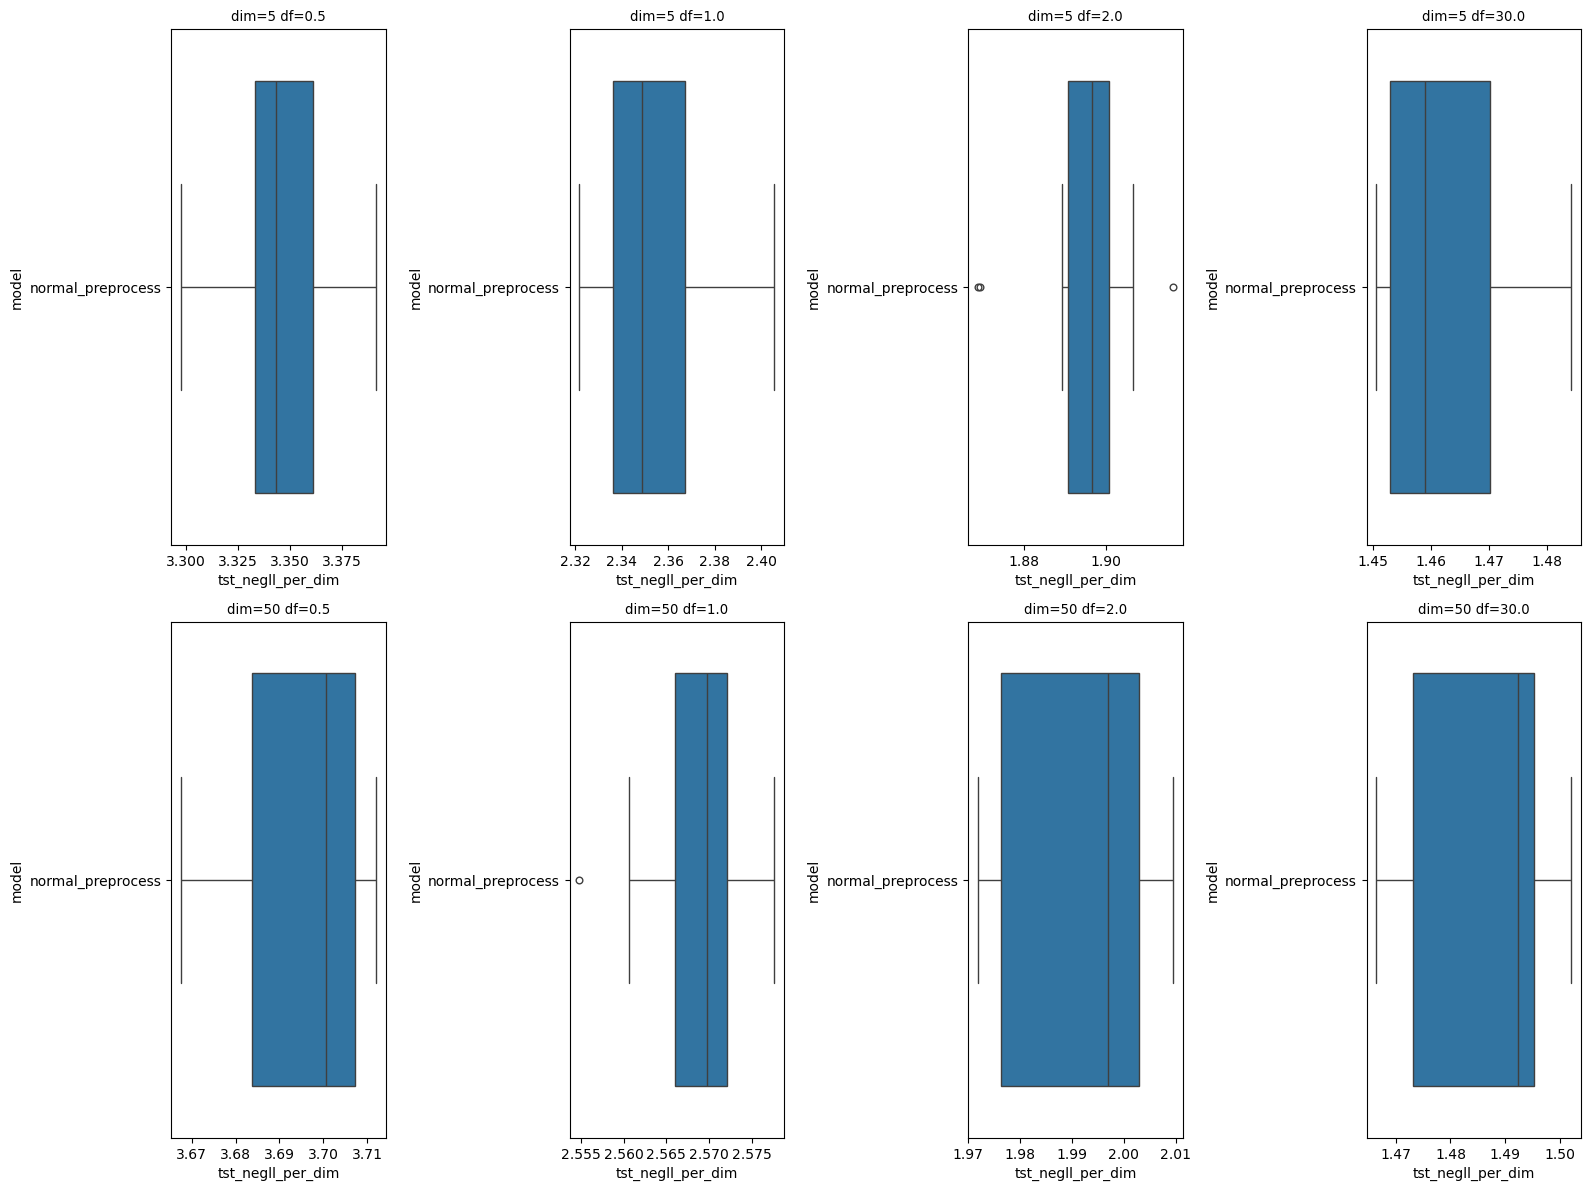

In [27]:
import seaborn as sns

wanted_dims = sorted(results['dim'].unique())
wanted_dfs = sorted(results['df'].unique())
wanted_models = results.model.unique()

fig, axarr = plt.subplots(len(wanted_dims), len(wanted_dfs), figsize=(16, 12), tight_layout=True)

if len(wanted_dims) == 1 and len(wanted_dfs) == 1:
  axarr = [[axarr]]

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.)

for i, dim in enumerate(wanted_dims):
  for j, nuisance_df in enumerate(wanted_dfs):
    wanted_data = results[np.logical_and(
        results['dim'] == dim,
        results['df'] == nuisance_df,
    )]

    sns.boxplot(
        data=wanted_data,
        x='tst_negll_per_dim',
        y='model',
        order=wanted_models,
        orient='h',
        ax=axarr[i][j],
    )

    axarr[i][j].set_title(f'dim={dim} df={nuisance_df:.1f}')

    # if j == 0:
      # axarr[i][j].set_xlim([0., 2.3])

In [29]:
agg = results.groupby(['dim', 'df', 'model'], group_keys=False).agg(['mean', 'sem'])

unpacked_rows = []
for (dim, df, model), test_neg_ll_agg in agg.iterrows():
    unpacked_rows.append(
        {
            'model': model,
            'df': df,
            'dim': dim,
            'tst_negll': test_neg_ll_agg.values[0],
            'sem': test_neg_ll_agg.values[1],
        }
    )

rezzas = pd.DataFrame(unpacked_rows)
rezzas

,model,df,dim,tst_negll,sem
0,normal_preprocess,0.5,5,3.345647,0.008075
1,normal_preprocess,1.0,5,2.354583,0.008338
2,normal_preprocess,2.0,5,1.893877,0.004733
3,normal_preprocess,30.0,5,1.462916,0.003997
4,normal_preprocess,0.5,50,3.695235,0.004816
5,normal_preprocess,1.0,50,2.568447,0.002168
6,normal_preprocess,2.0,50,1.991834,0.004747
7,normal_preprocess,30.0,50,1.486578,0.004424


In [57]:
def readable(row):
    if row["tst_negll"] > 10000 or np.isnan(row["tst_negll"]):
        return 'null'
    else:
        return  f'{row["tst_negll"]:.2f} ({row["sem"]:.2f})'
    
def interval(row):
    if row["tst_negll"] > 10000 or np.isnan(row["tst_negll"]):
        return 'null'
    else:
        return  f'[{row["tst_negll"] - row["sem"]:.4f}, {row["tst_negll"] + row["sem"]:.4f}]'
    
rezzas['readable'] = rezzas.apply(readable, axis=1)
rezzas['interval'] = rezzas.apply(interval, axis=1)

selector = np.logical_and(
    rezzas['dim'] == 5,
    np.isin(
        rezzas['df'], [0.5, 1., 2., 30.]
    ),
    # np.isin(
    #     rezzas['model'],
    #     ['TTF_m_affine_stable', 'TTF_m_stable']
    # )
)

res_tab = rezzas[selector].pivot(index='model', columns='df')['readable']
res_tab

df,0.5,1.0,2.0,30.0
model,,,,
TTF_m_fixed,3.49 (0.01),2.46 (0.01),2.00 (0.01),1.56 (0.00)
TTF_m_stable,3.51 (0.01),2.47 (0.01),2.00 (0.01),1.58 (0.01)
comet,3.30 (0.02),2.33 (0.01),1.87 (0.00),1.46 (0.00)
gTAF,5.32 (0.13),2.64 (0.02),2.07 (0.01),1.57 (0.00)
g_normal,null,NaN,NaN,NaN
mTAF,4.01 (0.03),2.60 (0.01),2.05 (0.01),1.55 (0.01)


In [58]:
order = {
    # 'normal': 'normal',
    # 'm_normal': 'm\_normal',
    # 'g_normal': 'g\_normal',
    # 'gTAF': 'gTAF',
    # 'TTF_m_affine_stable': 'TTF',
    # 'mTAF': 'mTAF',
    # 'TTF_m_affine_fixed': 'TTF (fix)',
    'comet': 'COMET'
}

for m_name, l_name in order.items():
    parsed_vals= [
        val if isinstance(val, str) else 'null'
        for val in res_tab.loc[m_name]
    ]
    print(f'& {l_name} &', ' & '.join(parsed_vals), ' \\\\')

& COMET & 3.30 (0.02) & 2.33 (0.01) & 1.87 (0.00) & 1.46 (0.00)  \\


In [16]:

for m_name, l_name in order.items():
    parsed_vals= [
        val if isinstance(val, str) else 'null'
        for val in res_tab.loc[m_name]
    ]
    print(f'& {l_name} &', ' & '.join(parsed_vals), ' \\\\')

KeyError: 'normal'